In [1]:
import numpy as np
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import nt_search
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandasql as ps
import time
import datetime
import itertools
from statistics import mean, stdev
import rapidfuzz
import string
import pprint
from BCBio.GFF import GFFExaminer
from BCBio import GFF


In [154]:
dfs = []
for i in range(1,9):
    df = pd.read_csv(f'ecoli_250window_{i}.csv')
    df['start_idx'] = df.index + (612371+250) * (i-1)
    dfs.append(df)
df = pd.concat(dfs)
df = df.set_index('start_idx')
df['start_idx'] = df.index

In [118]:
df_distinct = df.drop_duplicates(subset=['sd_seq'])

In [4]:
df_distinct

,length,sd_seq,start_idx
start_idx,,,
0,8,GTTACCTG,0
37,9,GTGCGGGCT,37
38,10,GGTGCGGGCT,38
54,11,AAAGCCCGCAC,54
55,12,AAAAGCCCGCAC,55
...,...,...,...
4899841,7,AATGCTA,4899841
4899842,8,AAATGCTA,4899842
4899959,6,ATGCTA,4899959


In [5]:
ecoli_gff = "Escherichia_coli_w_gca_000184185.ASM18418v1.56.chromosome.Chromosome.gff3"


In [6]:
# parse the GFF file using BCBio
with open(ecoli_gff) as handle:
    records = list(GFF.parse(handle))

# create an empty dataframe to store the results
df_list = []

# iterate over each record in the parsed GFF file
for record in records:
    for feature in record.features:
        # get the start and end coordinates of the feature
        start = feature.location.start.position
        end = feature.location.end.position

        # get the strand of the feature
        if feature.location.strand == 1:
            strand = '+'
        elif feature.location.strand == -1:
            strand = '-'
        else:
            strand = '.'

        # get the feature type and attributes
        feature_type = feature.type
        attributes = feature.qualifiers

        # get the sequence ID from the record
        seqid = record.id

        # create a new dataframe row with the extracted data
        row = pd.DataFrame({'seqid': [seqid], 'start': [start], 'end': [end], 
                            'strand': [strand], 'feature': [feature_type], 
                            'attributes': [attributes]})

        # append the row dataframe to the list
        df_list.append(row)

# concatenate all the dataframes in the list into a single dataframe
df2 = pd.concat(df_list, ignore_index=True)
df2['attributes'] = df2['attributes'].apply(str)
df2 = df2.drop(11)


In [7]:
df2.head(13)

,seqid,start,end,strand,feature,attributes
0,Chromosome,887177,887322,+,biological_region,"{'external_name': ['Moco RNA riboswitch'], 'lo..."
1,Chromosome,2353927,2354024,+,biological_region,{'external_name': ['TPP riboswitch; ECW_nc2306...
2,Chromosome,3398638,3398787,+,biological_region,{'external_name': ['FMN riboswitch; ECW_nc3308...
3,Chromosome,3450634,3450774,+,biological_region,"{'external_name': ['yybP-ykoY; ECW_nc3354'], '..."
4,Chromosome,3531759,3531874,-,biological_region,{'external_name': ['Ribosomal S15 leader; ECW_...
5,Chromosome,3655407,3655519,-,biological_region,{'external_name': ['alpha operon ribosome bind...
6,Chromosome,4428031,4428222,+,biological_region,{'external_name': ['cobalamin riboswitch; ECW_...
7,Chromosome,4459904,4460005,+,biological_region,{'external_name': ['TPP riboswitch; ECW_nc4353...
8,Chromosome,4499186,4499383,+,biological_region,{'external_name': ['lysine riboswitch; ECW_nc4...
9,Chromosome,4634595,4634642,+,biological_region,{'external_name': ['putative mini-ykkC riboswi...


<AxesSubplot:title={'center':'Distribution of invading sequence lengths'}>

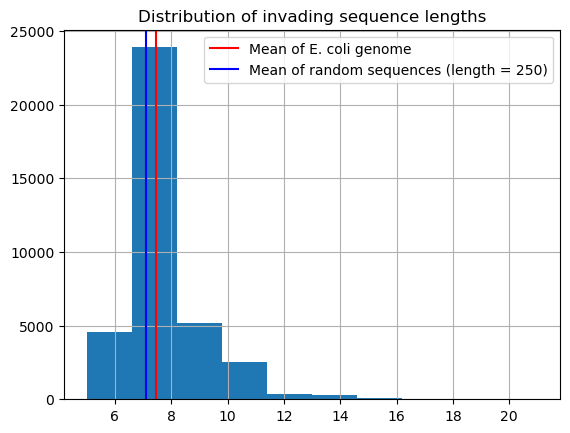

In [8]:
df_random = pd.read_csv('results/random_threshold_5_extra.csv')
random_mean = np.mean(df_random[df_random.seq_length == 250].length)
ecoli_mean = np.mean(df.length)
plt.axvline(x = ecoli_mean, color = 'r', label = 'Mean of E. coli genome')
plt.axvline(x = random_mean, color = 'b', label = 'Mean of random sequences (length = 250)')
plt.title('Distribution of invading sequence lengths')
plt.legend()
df_distinct.length.hist()

In [9]:
len(df2)


4759

In [10]:
np.max(df2.end)

4900944

In [11]:
df_ribo = df2[df2.attributes.str.contains('riboswitch')]
df_ribo['window_size'] = df_ribo.end - df_ribo.start

/tmp/ipykernel_6968/2431146924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ribo['window_size'] = df_ribo.end - df_ribo.start


In [12]:
df_ribo

,seqid,start,end,strand,feature,attributes,window_size
0,Chromosome,887177,887322,+,biological_region,"{'external_name': ['Moco RNA riboswitch'], 'lo...",145
1,Chromosome,2353927,2354024,+,biological_region,{'external_name': ['TPP riboswitch; ECW_nc2306...,97
2,Chromosome,3398638,3398787,+,biological_region,{'external_name': ['FMN riboswitch; ECW_nc3308...,149
6,Chromosome,4428031,4428222,+,biological_region,{'external_name': ['cobalamin riboswitch; ECW_...,191
7,Chromosome,4459904,4460005,+,biological_region,{'external_name': ['TPP riboswitch; ECW_nc4353...,101
8,Chromosome,4499186,4499383,+,biological_region,{'external_name': ['lysine riboswitch; ECW_nc4...,197
9,Chromosome,4634595,4634642,+,biological_region,{'external_name': ['putative mini-ykkC riboswi...,47


In [13]:
#TODO: run script over etnire riboswitch
# remove duplicates
# count how many are in non-annotated reegions
# check if 2 in protein coding and 1 in UTR or vice versa

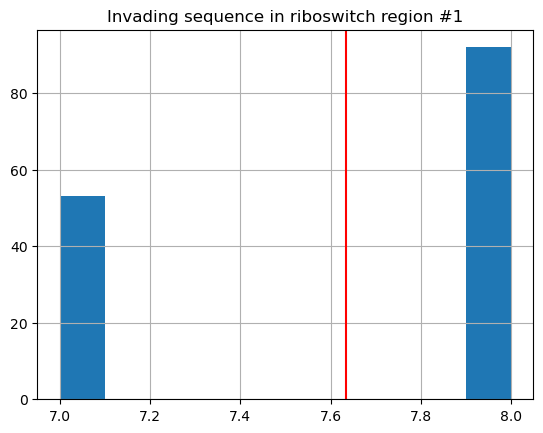

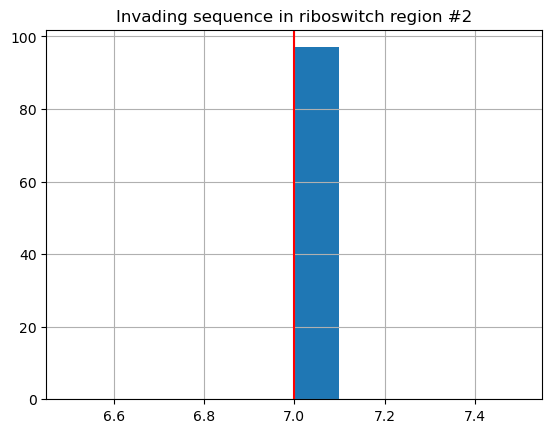

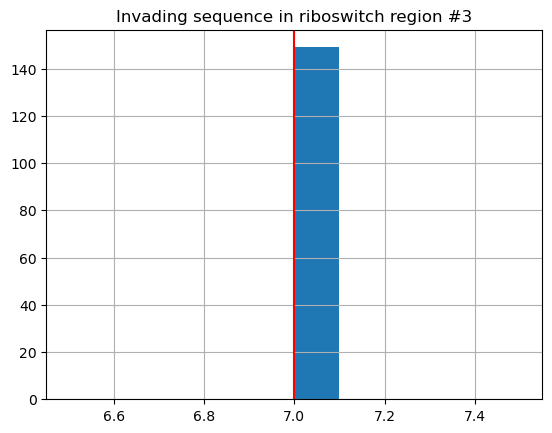

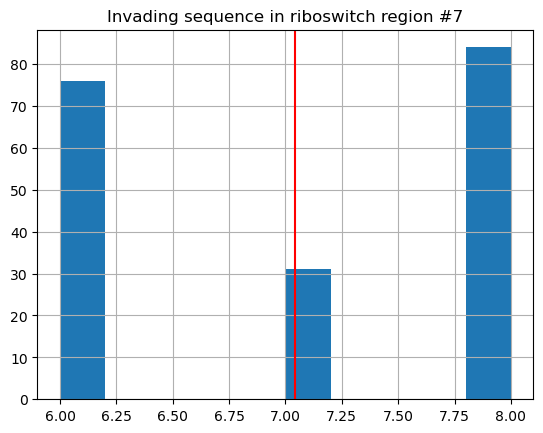

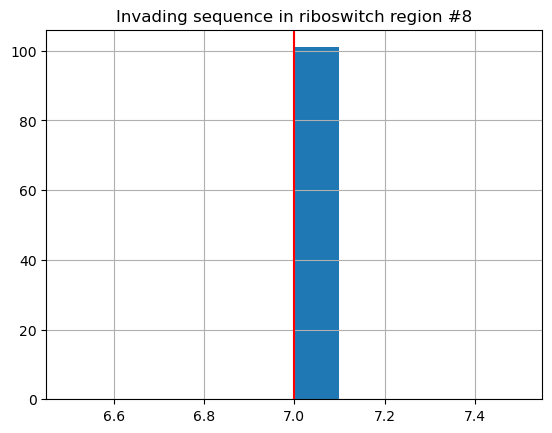

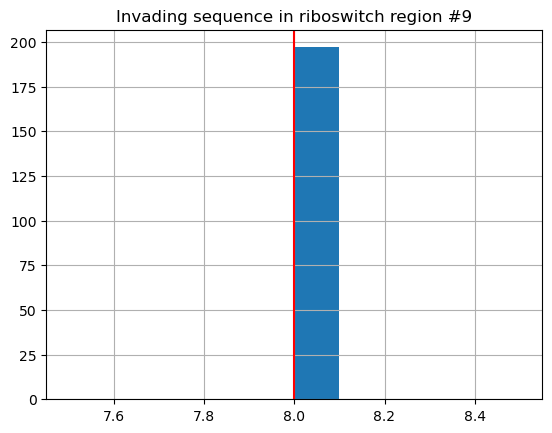

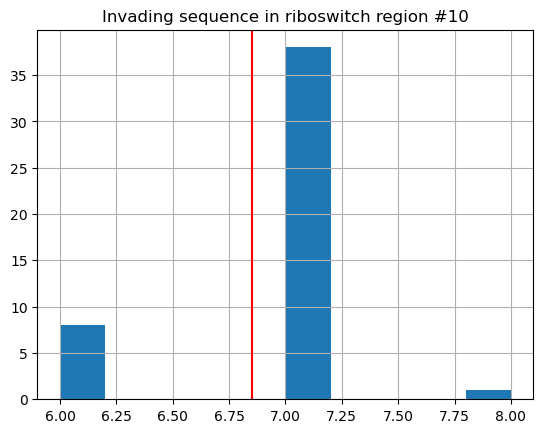

In [14]:
for i, row in df_ribo.iterrows():
    df_result = df[(df.index >= row.start) & (df.index < row.end)]
    plt.title('Invading sequence in riboswitch region #' + str(i+1))
    plt.axvline(x = df_result.length.mean(), color = 'r')
    df_result.length.hist()
    plt.show()
    

In [15]:
longest_sd_seqs = df.nlargest(50000, 'length')

# group by 'sd_seq' and aggregate 'start_idx' using the 'min' function
min_start_idx = longest_sd_seqs.groupby('sd_seq', as_index=False)['start_idx'].min()

# group by 'sd_seq' again and aggregate 'start_idx' using the 'max' function
max_start_idx = longest_sd_seqs.groupby('sd_seq', as_index=False)['start_idx'].max()
max_length = longest_sd_seqs.groupby('sd_seq', as_index=False)['length'].max()

# merge the aggregated DataFrames on 'sd_seq' to get the desired result
result = pd.merge(min_start_idx, max_start_idx, on='sd_seq')
result = pd.merge(result, max_length, on='sd_seq')

# rename the columns to 'start_idx' and 'end_idx'
longest_sd_seqs = result.rename(columns={'start_idx_x': 'start_idx', 'start_idx_y': 'end_idx'})
longest_sd_seqs

,sd_seq,start_idx,end_idx,length
0,AAAAAAACCACC,2331210,2331430,12
1,AAAAAAACCCGCC,3652321,3652543,13
2,AAAAAAATCCCCGGC,3374978,3375039,15
3,AAAAAAATCCCCGGCA,3375055,3375186,16
4,AAAAAACAGGAC,1093639,1093861,12
...,...,...,...,...
665,TTTTATGACCACAA,2677921,2678109,14
666,TTTTCTTTTATTT,3970997,3971197,13
667,TTTTTAAAATCA,2250246,2250329,12
668,TTTTTTAAAATC,2250266,2250285,12


In [ ]:
results = []
for i, row in longest_sd_seqs.iterrows():
    x = df2[((row.start_idx >= df2.start) & (row.start_idx <= df2.end)) | ((row.end_idx >= df2.start) & (row.end_idx <= df2.end)) ]
    if not x.empty:
        x['length'] = row.length
        results.append(x)
        


In [17]:
len(results)

519

In [18]:
print(len(results))
noncoding_results=[]
for result_df in results:
    if result_df.iloc[0].attributes.find('protein_coding') < 0:
        # print(result_df.iloc[0].length,result_df.iloc[0].attributes)
        noncoding_results.append(result_df.iloc[0].attributes)
print(len(noncoding_results))
print(len(noncoding_results) / len(results))

519
27
0.05202312138728324


## Calculate what percentage of the genome is annotated

In [19]:
def interval_length(df):
    # sort the DataFrame based on the 'start' column
    df = df.sort_values(by='start')

    # initialize an empty stack
    stack = []

    # iterate through the sorted intervals
    for i, row in df.iterrows():
        interval = (row['start'], row['end'])
        if not stack or interval[0] > stack[-1][1]:
            # if the stack is empty or if the current interval does not overlap with
            # the top interval on the stack, push the current interval onto the stack
            stack.append(interval)
        else:
            # if the current interval overlaps with the top interval on the stack,
            # merge the intervals by setting the end time of the top interval on the
            # stack to the maximum of its current end time and the end time of the
            # current interval
            stack[-1] = (stack[-1][0], max(stack[-1][1], interval[1]))

    # sum up the lengths of the merged intervals
    length = sum(end - start for start, end in stack)

    return stack, length


In [20]:
df2 = df2.sort_values(by='start')

# initialize an empty stack
stack = []

# iterate through the sorted intervals
for i, row in df2.iterrows():
    interval = (row['start'], row['end'])
    if not stack or interval[0] > stack[-1][1]:
        # if the stack is empty or if the current interval does not overlap with
        # the top interval on the stack, push the current interval onto the stack
        stack.append(interval)
    else:
        # if the current interval overlaps with the top interval on the stack,
        # merge the intervals by setting the end time of the top interval on the
        # stack to the maximum of its current end time and the end time of the
        # current interval
        stack[-1] = (stack[-1][0], max(stack[-1][1], interval[1]))

# sum up the lengths of the merged intervals
length = sum(end - start for start, end in stack)

In [21]:
non_annotated = set(range(4900718))
for interval in stack:
    start, end = interval
    non_annotated -= set(range(start, end+1))


In [22]:
seqs = []
start_idx = []
lengths = []
non_annotated = list(non_annotated)
for idx in non_annotated:
    try:
        seq = df.iloc[idx].sd_seq
        seqs.append(seq)
        lengths.append(len(seq))
        start_idx.append(idx)
    except:
        print(idx)

In [23]:
data = {'start_idx':start_idx, 'seq':seqs, 'length':lengths}
non_annotated_df = pd.DataFrame.from_dict(data)

<AxesSubplot:title={'center':'Invading strand length for non-annotated regions'}>

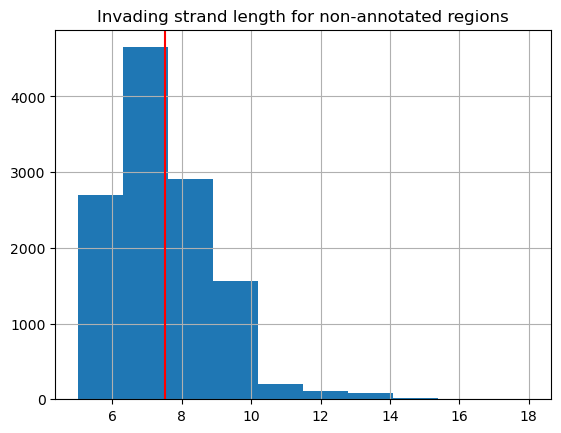

In [24]:
plt.axvline(x = np.mean(non_annotated_df.length), color = 'r')
plt.title('Invading strand length for non-annotated regions')
non_annotated_df.drop_duplicates(subset=['seq']).length.hist()

In [25]:
4373061/4900718

0.8923306748113236

In [26]:
results_df = pd.read_csv('combine_gff_results2.csv')

In [27]:
coding_df = results_df[results_df['attributes'].str.contains('protein_coding')]
noncoding_df = results_df[~results_df['attributes'].str.contains('protein_coding')]

In [28]:
interval_length(noncoding_df.drop_duplicates(subset=['start','end'])) / 4899477

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [29]:
interval_length(coding_df.drop_duplicates(subset=['start','end'])) / 4899477

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

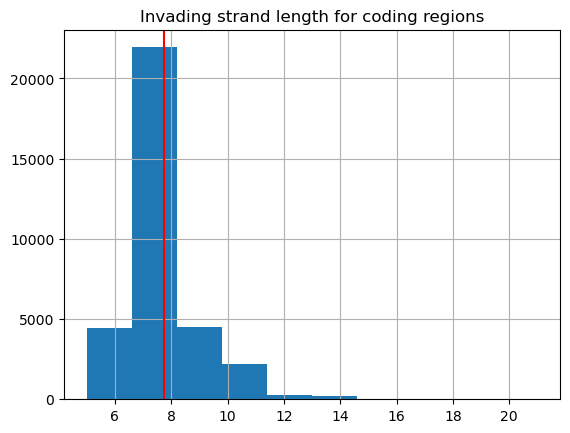

<AxesSubplot:title={'center':'Invading strand length for noncoding regions'}>

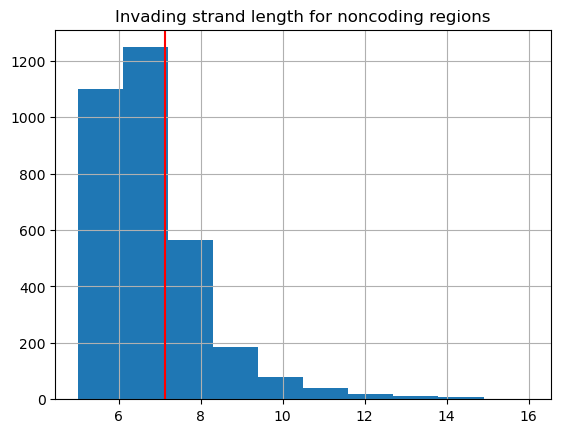

In [30]:
coding_df = coding_df.drop_duplicates(subset=['sd_seq'])
noncoding_df = noncoding_df.drop_duplicates(subset=['sd_seq'])
plt.axvline(x = np.mean(coding_df.length), color = 'r')
plt.title('Invading strand length for coding regions')
coding_df.length.hist()
plt.show()

plt.axvline(x = np.mean(noncoding_df.length), color = 'r')
plt.title('Invading strand length for noncoding regions')
noncoding_df.length.hist()

In [31]:
df_distinct.sort_index().reset_index(drop=True)['length'].rolling(100)

Rolling [window=100,center=False,axis=0,method=single]

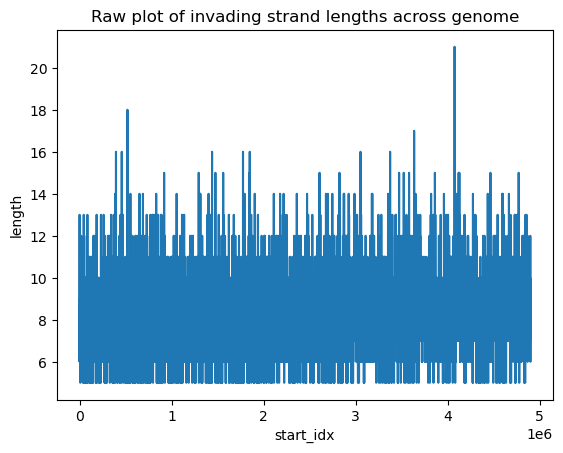

ValueError: Could not interpret value `length_smooth` for parameter `y`

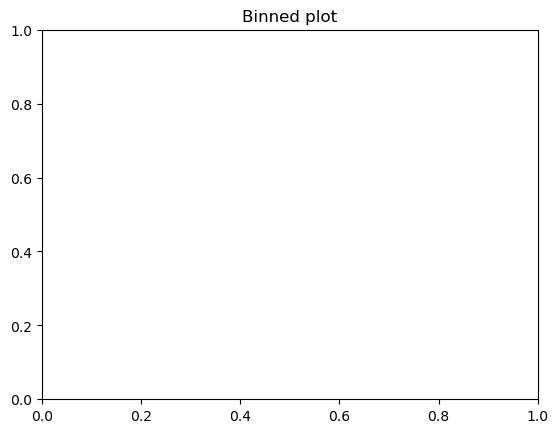

In [32]:
# Define the size of the rolling window
window_size = 100000

# Apply a rolling window to the length data
df['length_smooth'] = df.sort_index().reset_index(drop=True)['length'].rolling(1).mean()

# Plot the smoothed data using SNS lineplot
plt.title('Raw plot of invading strand lengths across genome')
sns.lineplot(data=df_distinct, x='start_idx', y='length')
plt.show()
plt.title('Binned plot')
sns.lineplot(data=df_distinct, x='start_idx', y='length_smooth')

<AxesSubplot:xlabel='start_idx', ylabel='length'>

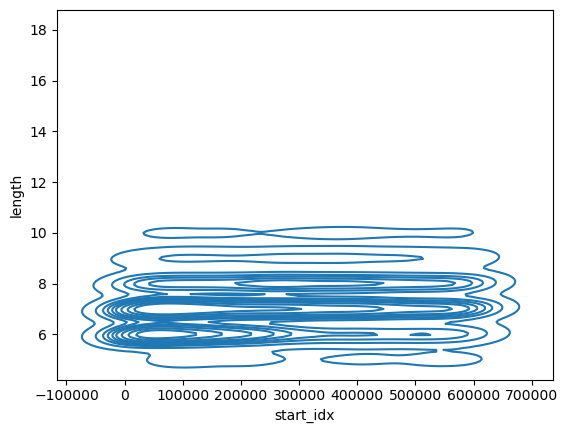

In [33]:
sns.kdeplot(data=df_distinct[:10000], x='start_idx', y='length')

In [34]:
sns.smoothplot(data=df[:100], x='start_idx', y='length')

AttributeError: module 'seaborn' has no attribute 'smoothplot'

In [ ]:
sns.splineplot(data=df[:100], x='start_idx', y='length')

In [ ]:
# plt.title('Violin plot ')
sns.violinplot(x=df_distinct['length'])


In [ ]:
df2

In [ ]:
df

In [98]:
coding_stack = interval_length(coding_df.drop_duplicates(subset=['start','end']))[0]
noncoding_stack = interval_length(noncoding_df.drop_duplicates(subset=['start','end']))[0]

In [156]:
df['coding_region'] = 0
df['noncoding_region'] = 0

In [121]:
coding_table = {}
for interval in coding_stack:
    for i in range(interval[0], interval[1]+1):
        coding_table[i] = 1
        
noncoding_table = {}
for interval in noncoding_stack:
    for i in range(interval[0], interval[1]+1):
        noncoding_table[i] = 1

In [122]:
def set_coding_region(idx):
    return 1 if idx in coding_table else 0
def set_noncoding_region(idx):
    return 1 if idx in noncoding_table else 0


In [157]:
df['coding_region'] = df['start_idx'].apply(set_coding_region)
df['noncoding_region'] = df['start_idx'].apply(set_noncoding_region)


In [158]:
df[180:200]

,length,sd_seq,start_idx,coding_region,noncoding_region
start_idx,,,,,
180,13,AAAAAAGCCCGCA,180,0,0
181,13,AAAAAAGCCCGCA,181,0,0
182,13,AAAAAAGCCCGCA,182,0,0
183,13,AAAAAAGCCCGCA,183,0,0
184,13,AAAAAAGCCCGCA,184,0,0
185,13,AAAAAAGCCCGCA,185,0,0
186,13,AAAAAAGCCCGCA,186,0,0
187,13,AAAAAAGCCCGCA,187,0,0
188,13,AAAAAAGCCCGCA,188,0,0


In [103]:
df[df['coding_region'] == 1]

,length,sd_seq,start_idx,length_smooth,coding_region,noncoding_region
start_idx,,,,,,


In [41]:
def extend_contiguous_stretches(df, n):
    # identify contiguous stretches of 1's
    is_contiguous_1 = df['coding_region'].ne(df['coding_region'].shift()) & df['coding_region'].eq(1)
    contiguous_groups = is_contiguous_1.cumsum()[is_contiguous_1]

    # extend each stretch by n values on either side
    for group in contiguous_groups:
        group_start = df.index.get_loc(df[df['coding_region'].eq(1)].iloc[group].name)
        group_end = df.index.get_loc(df[df['coding_region'].eq(1)].iloc[group+1].name)-1 if group < len(contiguous_groups)-1 else len(df)-1
        start_idx = max(0, group_start-n)
        end_idx = min(len(df), group_end+n+1)
        df.loc[df.iloc[start_idx:end_idx].index, 'coding_region'] = 1
    
    return df

In [42]:
def extend_coding_stretches(df, n):
    df['coding_region'] = df['coding_region'].rolling(2*n+1, center=True, min_periods=1).max()
    return df
def extend_noncoding_stretches(df, n):
    df['noncoding_region'] = df['noncoding_region'].rolling(2*n+1, center=True, min_periods=1).max()
    return df

In [43]:
extend_coding_stretches(df, 249)

,length,sd_seq,start_idx,length_smooth,coding_region,noncoding_region
start_idx,,,,,,
0,8,GTTACCTG,0,8.0,1.0,0
1,8,GTTACCTG,1,8.0,1.0,0
2,8,GTTACCTG,2,8.0,1.0,0
3,8,GTTACCTG,3,8.0,1.0,0
4,8,GTTACCTG,4,8.0,1.0,0
...,...,...,...,...,...,...
4900714,8,GCAACATT,4900714,NaN,1.0,0
4900715,8,GCAACATT,4900715,NaN,1.0,0
4900716,8,GCAACATT,4900716,NaN,1.0,0


In [44]:
extend_noncoding_stretches(df, 249)

,length,sd_seq,start_idx,length_smooth,coding_region,noncoding_region
start_idx,,,,,,
0,8,GTTACCTG,0,8.0,1.0,0.0
1,8,GTTACCTG,1,8.0,1.0,0.0
2,8,GTTACCTG,2,8.0,1.0,0.0
3,8,GTTACCTG,3,8.0,1.0,0.0
4,8,GTTACCTG,4,8.0,1.0,0.0
...,...,...,...,...,...,...
4900714,8,GCAACATT,4900714,NaN,1.0,0.0
4900715,8,GCAACATT,4900715,NaN,1.0,0.0
4900716,8,GCAACATT,4900716,NaN,1.0,0.0


In [171]:
df_both = df[(df['coding_region'] == 1) & (df['noncoding_region'] == 1)].drop_duplicates(subset=['sd_seq'])
df_coding = df[(df['coding_region'] == 1) & (df['noncoding_region'] == 0)].drop_duplicates(subset=['sd_seq'])
df_noncoding = df[(df['coding_region'] == 0) & (df['noncoding_region'] == 1)].drop_duplicates(subset=['sd_seq'])
df_neither = df[(df['coding_region'] == 0) & (df['noncoding_region'] == 0)].drop_duplicates(subset=['sd_seq'])
dfs = [df_both,df_coding,df_noncoding,df_neither]

In [172]:
df_plot = pd.DataFrame({'both':df_both.length, 'coding':df_coding.length, 'noncoding':df_noncoding.length, 'neither':df_neither.length})

<AxesSubplot:xlabel='Location of window on the genome', ylabel='Length of invading strand'>

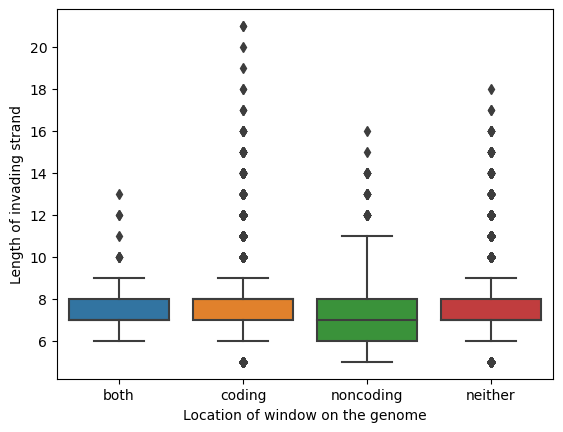

In [176]:
plt.ylabel('Length of invading strand')
plt.xlabel('Location of window on the genome')
sns.boxplot(df_plot)

In [50]:
df_ribo.start

0     887177
1    2353927
2    3398638
6    4428031
7    4459904
8    4499186
9    4634595
Name: start, dtype: int64

In [51]:
df_both.length.describe()

count    2902.000000
mean        7.377326
std         1.434041
min         5.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        17.000000
Name: length, dtype: float64

In [52]:
df_coding.length.describe()

count    35583.000000
mean         7.793834
std          1.362365
min          5.000000
25%          7.000000
50%          8.000000
75%          8.000000
max         21.000000
Name: length, dtype: float64

In [53]:
df_noncoding.length.describe()

count    2880.000000
mean        7.080903
std         1.265975
min         5.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        16.000000
Name: length, dtype: float64

In [54]:
df_neither.length.describe()

count    1814.000000
mean        7.055678
std         1.239490
min         5.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        15.000000
Name: length, dtype: float64

In [76]:
def find_closest_row(df, column_name, target_value):
    diff = (df[column_name] - target_value).abs()
    closest_row_idx = diff.idxmin()
    closest_row = df.loc[closest_row_idx]
    return closest_row

In [77]:
df_both.nlargest(10,'length')

,length,sd_seq,start_idx,length_smooth,coding_region,noncoding_region
start_idx,,,,,,
3636135,17,AAGCAAAAAGGCCATCC,3636135,7.0,1.0,1.0
3636172,16,AGCAAAAAGGCCATCC,3636172,7.0,1.0,1.0
2825000,15,GCAATAAAAAACCGC,2825000,7.0,1.0,1.0
2825072,15,CAATAAAAAACCGCC,2825072,8.0,1.0,1.0
3636173,15,GCAAAAAGGCCATCC,3636173,7.0,1.0,1.0
386505,14,AATAATGGCGTTGA,386505,14.0,1.0,1.0
1794137,14,TGAATTTTGTGATG,1794137,8.0,1.0,1.0
2825073,14,AATAAAAAACCGCC,2825073,8.0,1.0,1.0
2875205,14,TTCACGTTGTCGCC,2875205,7.0,1.0,1.0


In [184]:
descriptions_both = []
for i, row in df_both.nlargest(15, 'length').iterrows():
    desc1 = find_closest_row(df2,'start',row.start_idx).attributes
    desc2 = find_closest_row(df2,'end',row.start_idx).attributes
    descriptions_both.append((desc1,desc2))

In [227]:
import ast
dicts = [ast.literal_eval(df2.attributes.iloc[i]).get('biotype') for i in range(len(df2))]


In [231]:
dicts = [d[0] for d in dicts if d]

In [233]:
set(dicts)

{'ncRNA',
 'nontranslating_CDS',
 'protein_coding',
 'pseudogene',
 'rRNA',
 'tRNA',
 'tmRNA'}

In [185]:
print('Start of window, End of window')
descriptions_both


Start of window, End of window


[("{'ID': ['gene:ryjA'], 'biotype': ['ncRNA'], 'description': ['Novel sRNA, function unknown'], 'gene_id': ['ryjA'], 'logic_name': ['ena_rna'], 'source': ['ena']}",
  "{'ID': ['gene:ECW_m4428'], 'Name': ['soxR'], 'biotype': ['protein_coding'], 'description': ['DNA-binding transcriptional dual regulator, Fe-S center for redox-sensing'], 'gene_id': ['ECW_m4428'], 'logic_name': ['ena'], 'source': ['ena']}"),
 ("{'ID': ['gene:rncO'], 'biotype': ['ncRNA'], 'description': ['rncO'], 'gene_id': ['rncO'], 'logic_name': ['ena_rna'], 'source': ['ena']}",
  "{'ID': ['gene:ECW_m2796'], 'Name': ['rnc'], 'biotype': ['protein_coding'], 'description': ['RNase III'], 'gene_id': ['ECW_m2796'], 'logic_name': ['ena'], 'source': ['ena']}"),
 ("{'ID': ['gene:ryjA'], 'biotype': ['ncRNA'], 'description': ['Novel sRNA, function unknown'], 'gene_id': ['ryjA'], 'logic_name': ['ena_rna'], 'source': ['ena']}",
  "{'ID': ['gene:ECW_m4428'], 'Name': ['soxR'], 'biotype': ['protein_coding'], 'description': ['DNA-bindin

In [ ]:
#TODO: add mismatches between incumbent complimentary strands
# consider bulges (consecutive mismatches)

In [80]:
descriptions_nc = []
for i, row in df_noncoding.nlargest(15, 'length').iterrows():
    desc1 = find_closest_row(df2,'start',row.start_idx).feature
    desc2 = find_closest_row(df2,'end',row.start_idx).feature
    descriptions_nc.append((desc1,desc2))

In [141]:
print('Start of window, End of window')
descriptions_nc

Start of window, End of window


[('pseudogene', 'pseudogene'),
 ('pseudogene', 'pseudogene'),
 ('pseudogene', 'pseudogene'),
 ('pseudogene', 'pseudogene'),
 ('pseudogene', 'pseudogene'),
 ('pseudogene', 'pseudogene'),
 ('ncRNA_gene', 'ncRNA_gene'),
 ('ncRNA_gene', 'ncRNA_gene'),
 ('ncRNA_gene', 'ncRNA_gene'),
 ('ncRNA_gene', 'ncRNA_gene'),
 ('pseudogene', 'pseudogene'),
 ('ncRNA_gene', 'gene'),
 ('ncRNA_gene', 'gene'),
 ('ncRNA_gene', 'ncRNA_gene'),
 ('ncRNA_gene', 'ncRNA_gene')]

In [165]:
df_both = df[(df['coding_region'] == 1) & (df['noncoding_region'] == 1)]
df_coding = df[(df['coding_region'] == 1) & (df['noncoding_region'] == 0)]
df_noncoding = df[(df['coding_region'] == 0) & (df['noncoding_region'] == 1)]
df_neither = df[(df['coding_region'] == 0) & (df['noncoding_region'] == 0)]
dfs = [df_both,df_coding,df_noncoding,df_neither]

In [139]:
for i, row in df_ribo.iterrows():
    for df in dfs:
        result1 = df[df.start_idx == row.start]
        result2 = df[df.start_idx == row.start]
        if not result1.empty:
            print(result1, result2)


           length   sd_seq  start_idx  coding_region  noncoding_region
start_idx                                                             
887177          7  GATACGG     887177              0                 1            length   sd_seq  start_idx  coding_region  noncoding_region
start_idx                                                             
887177          7  GATACGG     887177              0                 1
           length   sd_seq  start_idx  coding_region  noncoding_region
start_idx                                                             
2353927         7  TTGTAAA    2353927              0                 1            length   sd_seq  start_idx  coding_region  noncoding_region
start_idx                                                             
2353927         7  TTGTAAA    2353927              0                 1
           length   sd_seq  start_idx  coding_region  noncoding_region
start_idx                                                             
339863